# Kasus

### Variables

In [41]:
# Variabel-variabel dan nilai-nilai yang diketahui
variabel = {
    'permintaan_naik': 5000,
    'permintaan_turun': 1000,
    'persediaan_naik': 600,
    'persediaan_turun': 100,
    'produksi_naik': 7000,
    'produksi_turun': 2000
}

soal = {
    'permintaan': 4000,
    'persediaan': 300
}

### Rules

In [42]:
# Aturan Fuzzy
rules = {
    'R1': {'kondisi1': 'permintaan_turun', 'kondisi2': 'persediaan_naik', 'kesimpulan': 'turun'},
    'R2': {'kondisi1': 'permintaan_turun', 'kondisi2': 'persediaan_turun', 'kesimpulan': 'turun'},
    'R3': {'kondisi1': 'permintaan_naik', 'kondisi2': 'persediaan_naik', 'kesimpulan': 'naik'},
    'R4': {'kondisi1': 'permintaan_naik', 'kondisi2': 'persediaan_turun', 'kesimpulan': 'naik'},
}

# Aturan Sugeno
sugeno_rules = {
    'R1': {'kondisi1': 'permintaan_turun', 'kondisi2': 'persediaan_naik'},
    'R2': {'kondisi1': 'permintaan_turun', 'kondisi2': 'persediaan_turun'},
    'R3': {'kondisi1': 'permintaan_naik', 'kondisi2': 'persediaan_naik'},
    'R4': {'kondisi1': 'permintaan_naik', 'kondisi2': 'persediaan_turun'},
}

### Functions

In [43]:
def turun(b, a, x):
    if x <= a:
        nilai = 1
    elif a < x < b:
        nilai = (b - x) / (b - a)
    elif x >= b:
        nilai = 0

    return nilai

def naik(b, a, x):
    if x <= a:
        nilai = 0
    elif a < x < b:
        nilai = (x - a) / (b - a)
    elif x >= b:
        nilai = 1

    return nilai

def agregasi_turun(b, a, alfa):
    nilai = b - (alfa * (b - a))
    return nilai

def agregasi_naik(b, a, alfa):
    nilai = alfa * (b - a) + a
    return nilai

# Fungsi produksi berdasarkan aturan Sugeno
def sugeno_rule(permintaan, persediaan, rule):
    if rule == 'R1':
        return permintaan - persediaan
    elif rule == 'R2':
        return permintaan
    elif rule == 'R3':
        return permintaan
    elif rule == 'R4':
        return 1.25 * permintaan - persediaan
    else:
        raise ValueError("Rule tidak valid")

# Fungsi inferensi Sugeno
def sugeno_inferensi(permintaan, persediaan):
    hasil = []
    for rule, kondisi in sugeno_rules.items():
        kondisi1 = kondisi['kondisi1']
        kondisi2 = kondisi['kondisi2']

        alfa = min(nk[kondisi1], nk[kondisi2])
        hasil_rule = sugeno_rule(permintaan, persediaan, rule) * alfa
        hasil.append(hasil_rule)

    return hasil

# Defuzifikasi Sugeno
def sugeno_defuzifikasi(hasil_inferensi):
    return sum(hasil_inferensi) / sum(alfa)


# Mamdani
# Fungsi keanggotaan untuk Permintaan
def permintaan_turun(x, batas_bawah=variabel['permintaan_turun'], batas_atas=variabel['permintaan_naik']):
    if x <= batas_bawah:
        return 1
    elif x > batas_bawah and x < batas_atas:
        return (batas_atas - x) / (batas_atas - batas_bawah)
    else:
        return 0

def permintaan_naik(x, batas_bawah=variabel['permintaan_turun'], batas_atas=variabel['permintaan_naik']):
    if x >= batas_atas:
        return 1
    elif x < batas_atas and x > batas_bawah:
        return (x - batas_bawah) / (batas_atas - batas_bawah)
    else:
        return 0

# Fungsi keanggotaan untuk Persediaan
def persediaan_banyak(x, batas_bawah=variabel['persediaan_turun'], batas_atas=variabel['persediaan_naik']):
    if x <= batas_bawah:
        return 1
    elif x > batas_bawah and x < batas_atas:
        return (batas_atas - x) / (batas_atas - batas_bawah)
    else:
        return 0

def persediaan_sedikit(x, batas_bawah=variabel['persediaan_turun'], batas_atas=variabel['persediaan_naik']):
    if x >= batas_atas:
        return 1
    elif x < batas_atas and x > batas_bawah:
        return (x - batas_bawah) / (batas_atas - batas_bawah)
    else:
        return 0

# Fungsi Implikasi
def implikasi(permintaan, persediaan):
    rules = []
    rules.append(min(permintaan_turun(permintaan), persediaan_banyak(persediaan))) # R1
    rules.append(min(permintaan_turun(permintaan), persediaan_sedikit(persediaan))) # R2
    rules.append(min(permintaan_naik(permintaan), persediaan_banyak(persediaan))) # R3
    rules.append(min(permintaan_naik(permintaan), persediaan_sedikit(persediaan))) # R4
    return rules

# Fungsi untuk Komposisi Antar Aturan
def komposisi(rules, batas_bawah=variabel['produksi_turun'], batas_atas=variabel['produksi_naik']):
    a1 = batas_bawah + min(rules) * (batas_atas - batas_bawah)
    a2 = batas_bawah + max(rules) * (batas_atas - batas_bawah)

    def hasil(z):
        if z <= a1:
            return min(rules)
        elif z > a1 and z < a2:
            return (z - batas_bawah) / (batas_atas - batas_bawah)
        else:
            return max(rules)

    return a1, a2, hasil

from scipy import integrate
from scipy.integrate import quad

# Definisikan fungsi yang ingin Anda integralkan
def f(x, val):
    return val * x

# Fungsi yang akan diintegralkan
def integrand(x, prod_turun, perm_naik):
    return (x - prod_turun) * x / perm_naik

# Fungsi untuk Penegasan (Defuzzy)
def defuzzy(rules, a1, a2, hasil):

    #M1
    val_m1 = min(rules)
    m1, error = integrate.quad(f, 0, a1, args=(val_m1,))
    print("\nNilai M1:", m1)


    #M2
    # Batas bawah dan batas atas integrasi
    lower_limit = a1
    upper_limit = a2

    # Nilai untuk prod_turun dan perm_naik
    prod_turun_value = variabel["produksi_turun"]
    perm_naik_value = variabel["permintaan_naik"]

    # Menggunakan quad untuk menghitung integral
    m2, error = quad(integrand, lower_limit, upper_limit, args=(prod_turun_value, perm_naik_value))
    print("Nilai M2:", m2)


    #M3
    # Batas bawah dan batas atas integral
    a = 5000
    b = 7000
    val_m3 = max(rules)

    # Hitung integral
    m3, error = quad(f, a, b, args=(val_m3,))

    print("Nilai M3:", m3)

    A1 = a1 * min(rules)
    A2 = (min(rules) + max(rules)) * (a2 - a1) / 2
    A3 = (variabel['produksi_naik'] - a2) * max(rules)

    print("\nHasil Hitung Luas:")
    print(f"A1: {A1:.2f}")
    print(f"A2: {A2:.2f}")
    print(f"A3: {A3:.2f}")

    total_area = A1 + A2 + A3
    z = (m1 + m2 + m3) / total_area

    return z

# Main Function
def main(permintaan, persediaan):
    rules = implikasi(permintaan, persediaan)
    a1, a2, hasil_komposisi = komposisi(rules)
    hasil_defuzzy = defuzzy(rules, a1, a2, hasil_komposisi)
    return hasil_defuzzy

#1. Tsukamoto

In [44]:
# Menghitung nilai linguistik
nk = dict()
for i in soal:
    up = naik(variabel[i+"_naik"], variabel[i+"_turun"], soal[i])
    down = turun(variabel[i+"_naik"], variabel[i+"_turun"], soal[i])
    nk.update({i+"_naik": up})
    nk.update({i+"_turun": down})

print("Nilai Linguistik:")
for var, value in nk.items():
    print(f"{var}: {value:}")

# Agregasi
alfa = []
z = []

for rule in rules.values():
    kondisi1 = rule['kondisi1']
    kondisi2 = rule['kondisi2']
    kesimpulan = rule['kesimpulan']

    a = min(nk[kondisi1], nk[kondisi2])
    alfa.append(a)

    if kesimpulan == "turun":
        zz = agregasi_turun(variabel['produksi_naik'], variabel['produksi_turun'], a)
    elif kesimpulan == "naik":
        zz = agregasi_naik(variabel['produksi_naik'], variabel['produksi_turun'], a)

    z.append(zz)

# Menampilkan nilai alfa
print("\nNilai Alfa:")
for i, a in enumerate(alfa):
    print(f"Alfa-{i+1}: {a:}")

# Menampilkan nilai z
print("\nNilai Z:")
for i, nilai_z in enumerate(z):
    print(f"Z-{i+1}: {nilai_z:}")


# Defuzifikasi
df = sum(alfa[i] * z[i] for i in range(len(alfa)))
defuz = int(df / sum(alfa))

print("\nDefuzifikasi:")
print(f"Jadi, nilai produksi adalah {defuz}")

Nilai Linguistik:
permintaan_naik: 0.25
permintaan_turun: 0.75
persediaan_naik: 0
persediaan_turun: 1

Nilai Alfa:
Alfa-1: 0
Alfa-2: 0.75
Alfa-3: 0
Alfa-4: 0.25

Nilai Z:
Z-1: 7000
Z-2: 3250.0
Z-3: 2000
Z-4: 3250.0

Defuzifikasi:
Jadi, nilai produksi adalah 3250


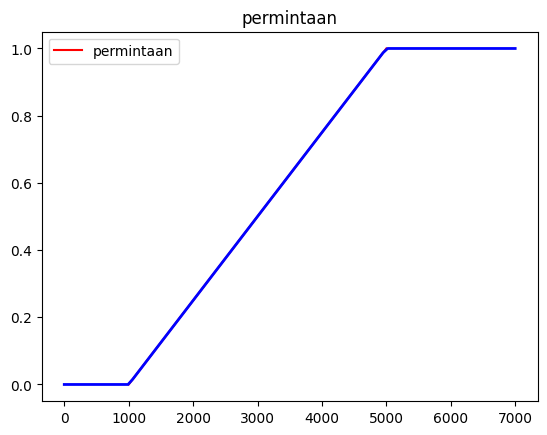

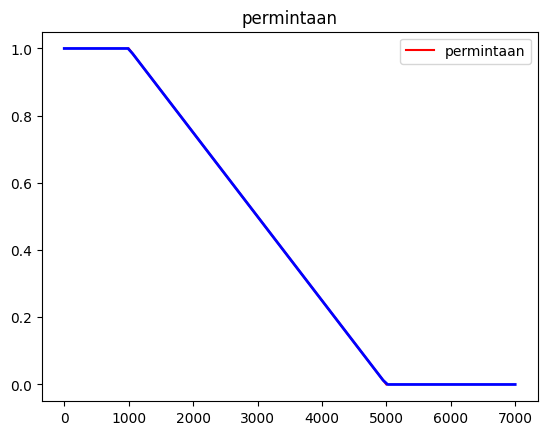

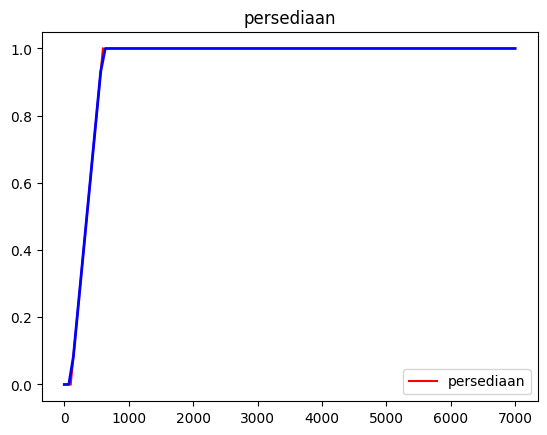

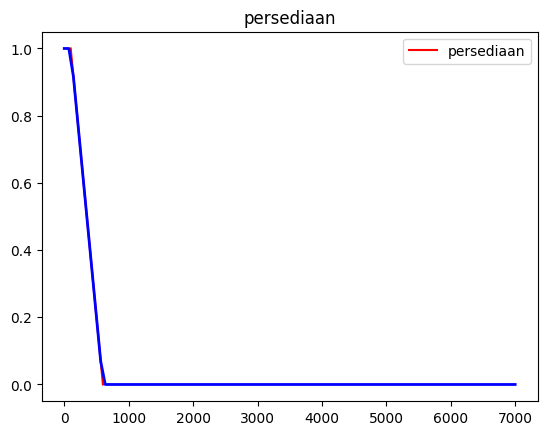

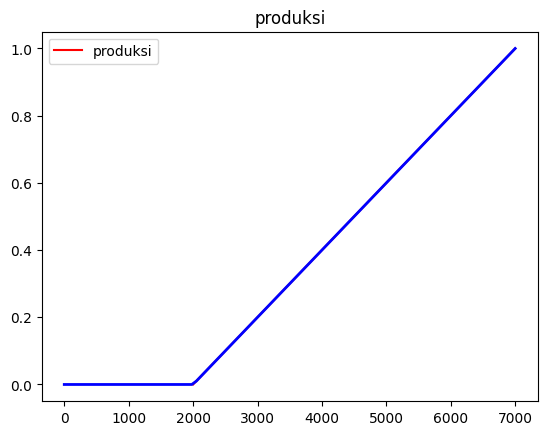

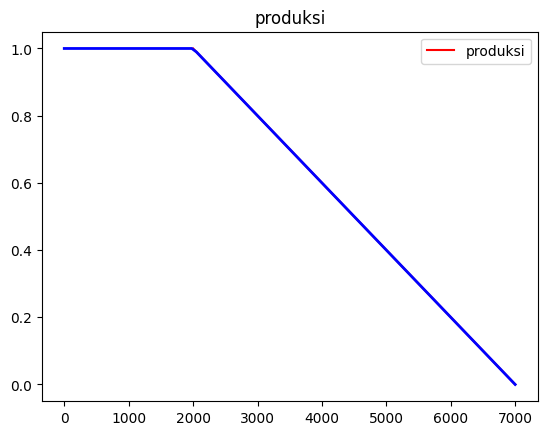

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Fungsi turun
def plot_turun(b, a, x, nama):
    nilai = [turun(b, a, i) for i in x]
    plt.plot([a, b], [1, 0], 'r', label=nama)
    plt.plot(x, nilai, 'b', linewidth=2)
    plt.title(nama)
    plt.legend()
    plt.show()

# Fungsi naik
def plot_naik(b, a, x, nama):
    nilai = [naik(b, a, i) for i in x]
    plt.plot([a, b], [0, 1], 'r', label=nama)
    plt.plot(x, nilai, 'b', linewidth=2)
    plt.title(nama)
    plt.legend()
    plt.show()

# Plot fungsi keanggotaan untuk setiap variabel
x = np.linspace(0, 7000, 100)

for var in variabel.keys():
    if var.endswith("_naik"):
        nama_var = var[:-5]
        plot_naik(variabel[nama_var+"_naik"], variabel[nama_var+"_turun"], x, nama_var)
    elif var.endswith("_turun"):
        nama_var = var[:-6]
        plot_turun(variabel[nama_var+"_naik"], variabel[nama_var+"_turun"], x, nama_var)


# 2. Sugeno

In [46]:
# Penggunaan fungsi-fungsi Sugeno
hasil_inferensi_sugeno = sugeno_inferensi(soal['permintaan'], soal['persediaan'])
defuz_sugeno = sugeno_defuzifikasi(hasil_inferensi_sugeno)

print("Jadi, nilai produksi (Sugeno) adalah", defuz_sugeno)

Jadi, nilai produksi (Sugeno) adalah 2100.0


# 3. Mamdani

In [47]:
# Input Permintaan dan Persediaan
permintaan = soal['permintaan']
persediaan = soal['persediaan']

# Melakukan implikasi untuk mencari nilai pada setiap aturan
rules = implikasi(permintaan, persediaan)

# Menampilkan output nilai hasil implikasi
print("Hasil Implikasi:")
for i, rule_value in enumerate(rules):
    print(f"R{i+1}: {rule_value:.2f}")

# Melakukan komposisi antar aturan untuk mencari nilai akhir
a1, a2, hasil_komposisi = komposisi(rules)

# Menampilkan output nilai hasil komposisi antar aturan
print("\nHasil Komposisi Antar Aturan:")
print(f"a1: {a1:.2f}")
print(f"a2: {a2:.2f}")

hasil = main(permintaan, persediaan)
print("\nHasil Defuzzyfikasi:")
print(f"Jumlah kemasan makanan jenis ABC yang harus diproduksi: {hasil}")

Hasil Implikasi:
R1: 0.75
R2: 0.00
R3: 0.25
R4: 0.00

Hasil Komposisi Antar Aturan:
a1: 2000.00
a2: 5750.00

Nilai M1: 0.0
Nilai M2: 6328125.000000001
Nilai M3: 9000000.000000002

Hasil Hitung Luas:
A1: 0.00
A2: 1406.25
A3: 937.50

Hasil Defuzzyfikasi:
Jumlah kemasan makanan jenis ABC yang harus diproduksi: 6540.000000000002


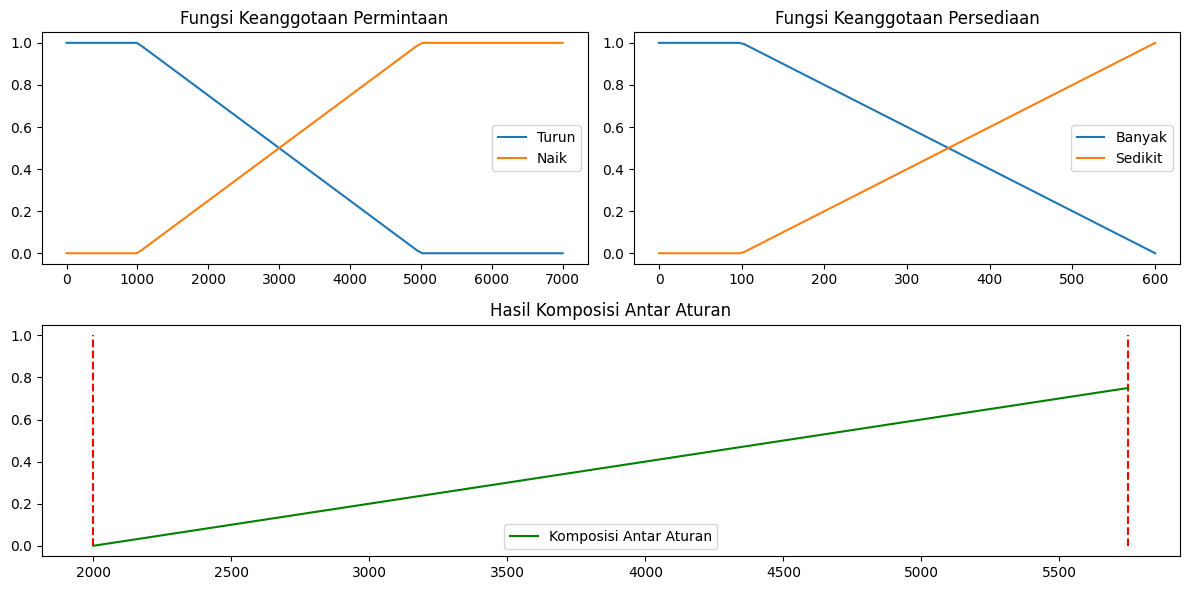

In [48]:
# Plotting grafik untuk setiap fungsi keanggotaan
x_permintaan = np.linspace(0, 7000, 100)
x_persediaan = np.linspace(0, 600, 100)

plt.figure(figsize=(12, 6))

# Plotting fungsi keanggotaan Permintaan
plt.subplot(2, 2, 1)
plt.plot(x_permintaan, [permintaan_turun(x) for x in x_permintaan], label='Turun')
plt.plot(x_permintaan, [permintaan_naik(x) for x in x_permintaan], label='Naik')
plt.title('Fungsi Keanggotaan Permintaan')
plt.legend()

# Plotting fungsi keanggotaan Persediaan
plt.subplot(2, 2, 2)
plt.plot(x_persediaan, [persediaan_banyak(x) for x in x_persediaan], label='Banyak')
plt.plot(x_persediaan, [persediaan_sedikit(x) for x in x_persediaan], label='Sedikit')
plt.title('Fungsi Keanggotaan Persediaan')
plt.legend()

# Plotting hasil komposisi
plt.subplot(2, 1, 2)
rules = implikasi(permintaan, persediaan)
a1, a2, hasil_komposisi = komposisi(rules)
plt.plot([a1, a1], [0, 1], 'r--')
plt.plot([a2, a2], [0, 1], 'r--')
plt.plot([a1, a2], [hasil_komposisi(a1), hasil_komposisi(a2)], 'g', label='Komposisi Antar Aturan')
plt.title('Hasil Komposisi Antar Aturan')
plt.legend()

plt.tight_layout()
plt.show()